In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [1]:
import imp
import rp_experiments
import gp_helpers
import pandas as pd
import matplotlib.pyplot as plt
imp.reload(rp_experiments)
imp.reload(gp_helpers)

<module 'gp_helpers' from '/Users/idelbridge/Scalable_GPs/gp_helpers.py'>

# Description of the experiments run

Define the random projection kernel as follows:

$k_{RP}(x_1, x_2) = \sum_{j=1}^J \frac{1}{J}\exp(-\frac{1}{2 l_j^2} ||P^{(j)} x_1 - P^{(j)} x_2||_2^2),$

where each $P^{(j)}$ is a $k \times d$ random projection matrix with elements sampled from $\frac{1}{\sqrt{k}}N(0,1)$. Hyerparameters of the kernel are the number of projections $J$, the size of projections $k$, and length scales $l_1, ..., l_{J}$.

In all of the following experiments, each Gaussian process's hyperparameters (which are lengthscales, Gaussian observation noise variance, and kernel scale) were fitted through minimization of the negative log marginal likelihood. The optimization was performed using ADAM with learning rate 0.1, training until convergence, which is determined when the moving average of the loss decreases by less than 1e-4 after 20 epochs.

Each dataset is normalized as a whole (instead of just using training data) with 0 mean and unit variance for all features and target variables.

The first experiment shown below tracks the test log likelihood and mean squared error of Gaussian processes with random projection kernels as k and J are varied. These metrics are also compared with the RBF kernel. For each regreession dataset in the UCI repository up to at most 2565 data points, a total of 22 models are compared: a single RBF GP and the RP GP with k=1, k=4, or k=10 and J=1,2,3,5,8,13,20. For each model, 10-fold cross-validation is performed twice in order to obtain good estimates of average performance. Plots show the median and interquartile range of NLL or MSE at each point.

In the second experiment below, the k and J were fixed to 1 and 20 respectively, and the weights of the projection matrices were trained along with GP hyperparameters using the same training procedure on the same datasets with 2 10-fold cross-validations. Box and whisker plots are shown to summarize the performance of such a GP compared to RP kernel with k=1 & J=20, RP kernel with k=4 & J=20, and an RBF kernel.

Note that, to stabilize training, 
* LBFGS is replaced by ADAM. It empirically caused faster, more frequent convergence to a bad optimum where noise collapses. Also, Alex noted that Adam may be better since the gradients are computed with CG and are therefore a little noisy, and that anecdotally the Pytorch implementation isn't very good.
* CG tolerance is decreased from 0.05 to 0.01 for extra precaution. Using no Cholesky solves didn't fix things, and CG worked well after switching to ADAM.
* A liberal box prior is set over observation noise to enforce soft constraints that noise >1e-4 and <10.

In [3]:
def make_plot(k, dataset, robust=True, color='green', plot_bl=True, show_range=True, ds=None, 
              metric='test_nll', label=None):
    ex = ds[ds['dataset'] == dataset].iloc[0]
    dset = ds[ds['dataset'] == dataset]

    n = ex['n']
    d = ex['d']
    values = dset[~dset['RP']][metric].dropna()
    if not robust:
        bl_middle = values.mean()
        bl_below = bl_middle - 2*values.std()
        bl_above = bl_middle + 2*values.std()

        middle_line = dset[dset['RP'] & (dset['k'] == k)].groupby('J')[metric].mean()
        below_line = middle_line - 2*dset[dset['RP'] & (dset['k'] == k)].groupby('J')[metric].std()
        above_line = middle_line + 2*dset[dset['RP'] & (dset['k'] == k)].groupby('J')[metric].std()
    else:
        middle_line = dset[dset['RP'] & (dset['k'] == k)].groupby('J')[metric].median()
        below_line = dset[dset['RP'] & (dset['k'] == k)].groupby('J')[metric].quantile(0.25)
        above_line = dset[dset['RP'] & (dset['k'] == k)].groupby('J')[metric].quantile(0.75)
    
    if plot_bl:
        try:
            bl_middle = np.median(values)
            bl_below = np.percentile(values, 25)
            bl_above = np.percentile(values, 75)
        except Exception:
            print(k, dataset)
            raise
        plt.axhline(bl_middle, color='blue', label='SE')
        plt.fill_between([0, 20], bl_below, bl_above, color='blue', alpha=0.2)
    
    if label is None:
        label = 'RP+SE,k={}'.format(k)
    plt.plot(middle_line.index, middle_line.values, color=color, marker='o', label=label)
    if show_range:
        plt.fill_between(below_line.index, below_line.values, above_line.values, color=color, alpha=0.2)
    plt.title(dataset + ' (n={}, d={})'.format(n, d))
    plt.xlabel("J")
    plt.ylabel(metric)

# Plots of Sensitivity Study on k, J
Comments:
* Dataset "gas" was terminated early because it took so long.
* NLL is more prone to unreasonable outlying values because sometimes despite all of the above precautions some kind of bad optimum is reached. I think it is when noise collapses, but I'm not sure it is always the case.
* RP with k=1 converges to a better MSE and NLL as expected, but does not always meet the performance of when k=4 or k=10. I think this could be the case when nonlinear feature interactions are important to the target variable. 
* RP with k=1 sometimes converges to a performance much better than k=4 or k=10. This might be occurring because ARD is not being used. If the target variable is constant w.r.t. some dimensions but quickly varying in one or more dimensions, RBF with no ARD could not model it, and similarly neither could an RP kernel with k=4,10. However, if this were the case, we'd expect that the RP with k=1 would perform better than the RBF.
* RP with k=10 is often not close to the RBF performance. This *may* be an artifact of initialization and/or numerical error - for a dataset where this occurs, I noticed that, as initialized, kernel values were very small (though similar to the values of the RBF kernel). I was wrong about the initialization of lengthscales - it is by default less than 1. I tried initializing to a higher lengthscale and got much better results, though still not equal to that of the RBF.

In [46]:
df_with_se = pd.read_csv('./full-run-ADAM-smoothed-lowish-cg-tol-noise-prior.csv')  
se_runs = df_with_se[df_with_se['RP'] == False]
df = pd.read_csv('./full-correct-proj-scale-full-run-ADAM-smoothed-lowish-cg-tol-noise-prior.csv')
df_extra = pd.read_csv("./simul-correct-proj-scale-full-run-ADAM-smoothed-lowish-cg-tol-noise-prior.csv")
df = df.append(se_runs)
df = df.append(df_extra)

In [47]:
df.loc[df['RP']==False, ['k', 'J']] = 0

## NLL

challenger
fertility
concreteslump
autos
servo
breastcancer
machine
yacht
autompg
housing
forest
stock
pendulum
energy
concrete
solar
airfoil
wine
gas


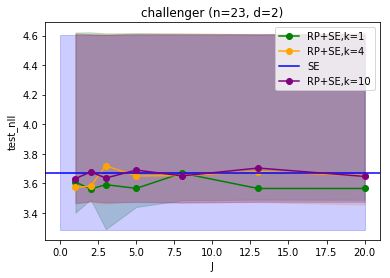

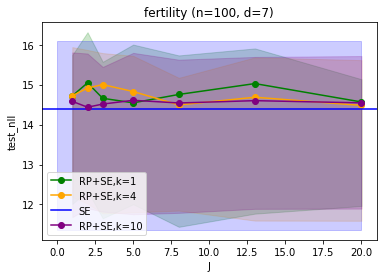

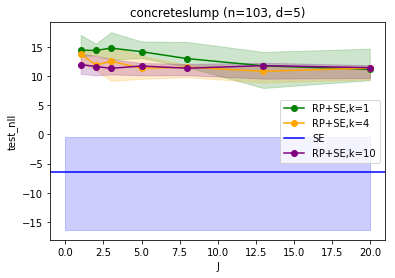

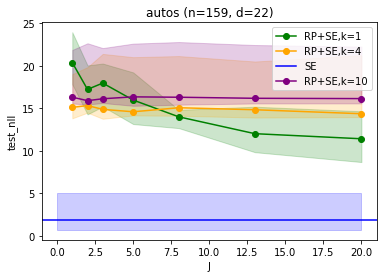

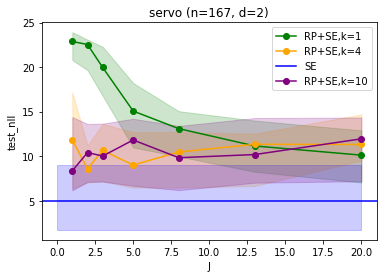

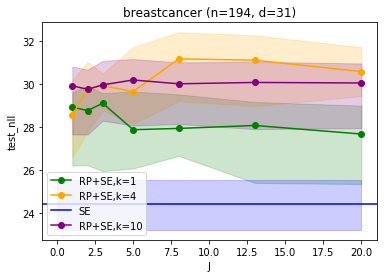

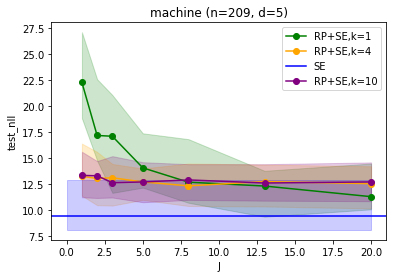

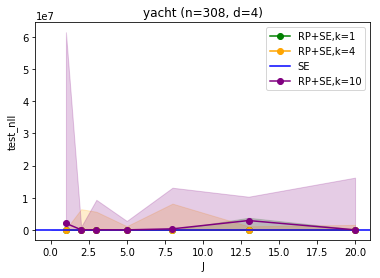

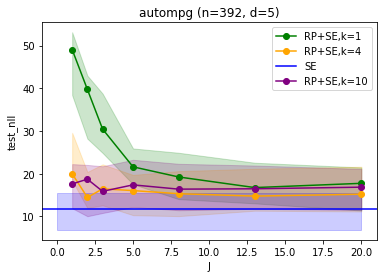

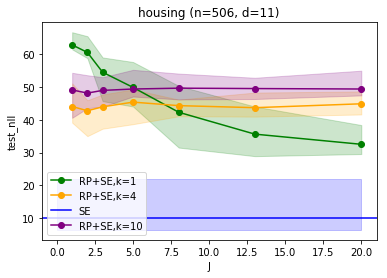

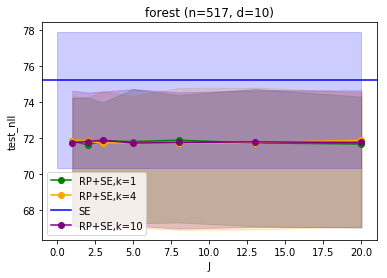

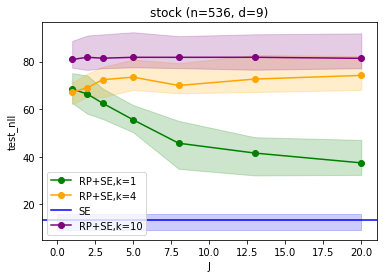

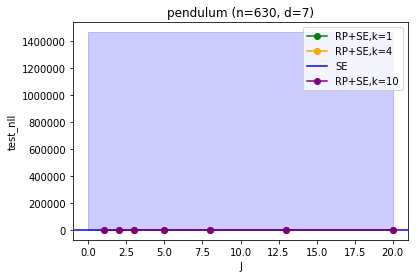

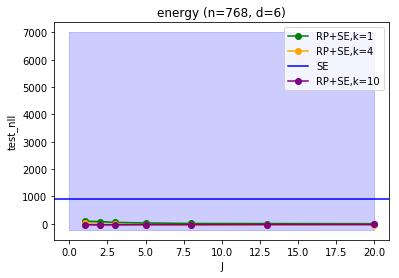

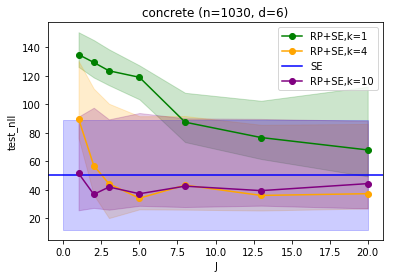

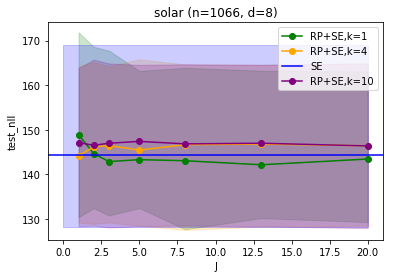

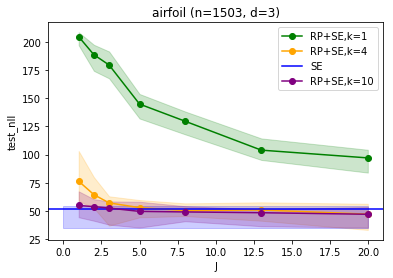

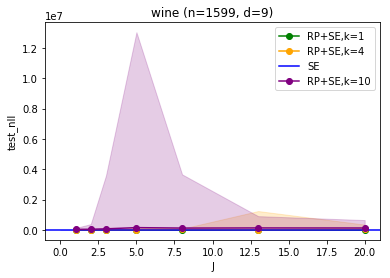

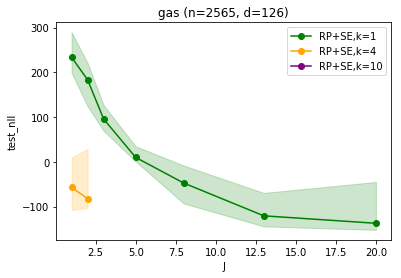

In [50]:
maxlim_list = {}
for dataset in df[df['RP'] == True]['dataset'].unique():
    plt.figure()
    make_plot(1, dataset, show_range=True,  ds=df, plot_bl=False, robust=True, metric='test_nll')
    make_plot(4, dataset, show_range=True,  ds=df, plot_bl=False, color='orange', robust=True, metric='test_nll')
    if dataset == 'gas':
        make_plot(10, dataset, show_range=True,  ds=df, plot_bl=False, color='purple', robust=True, metric='test_nll')
    else:
        make_plot(10, dataset, show_range=True,  ds=df, plot_bl=True, color='purple', robust=True, metric='test_nll')
    if dataset in maxlim_list.keys():
        plt.ylim(maxlim_list[dataset])
    plt.legend()

## MSE

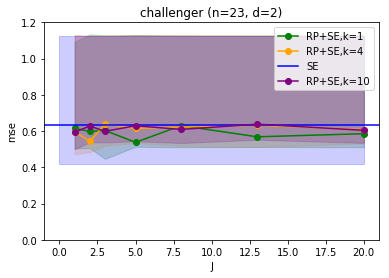

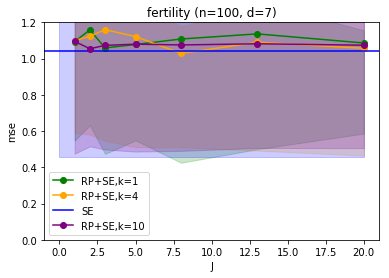

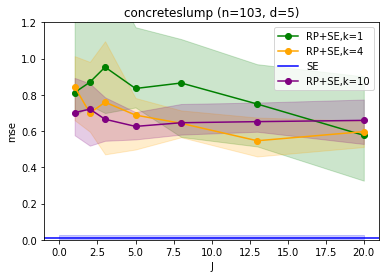

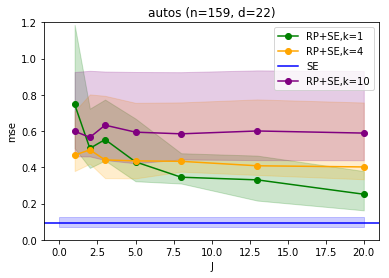

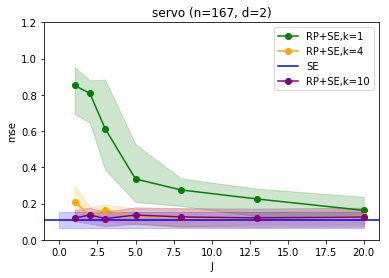

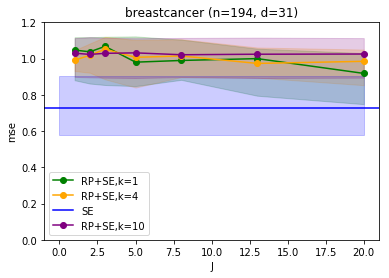

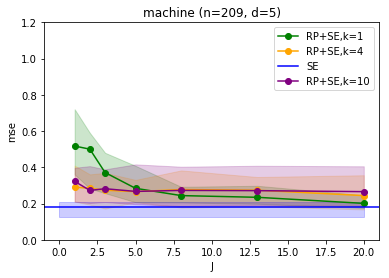

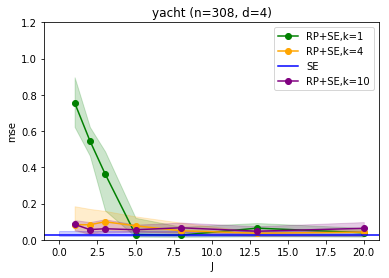

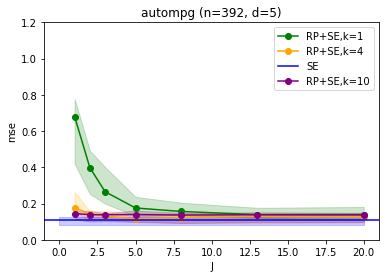

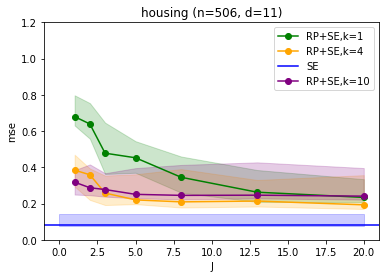

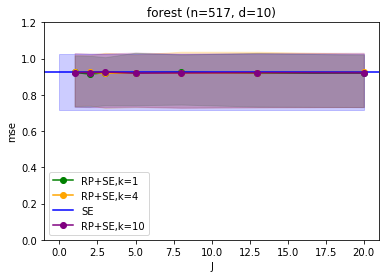

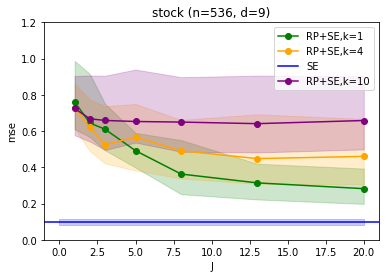

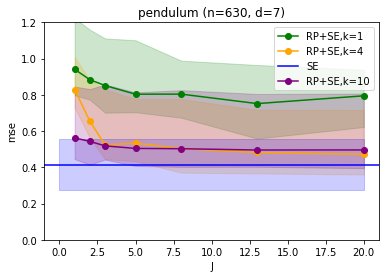

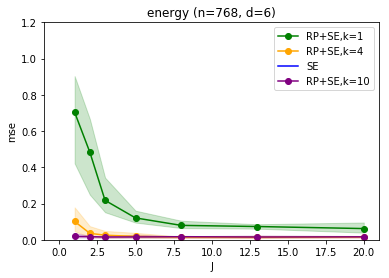

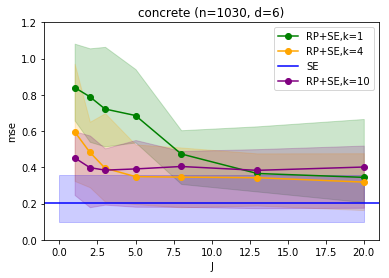

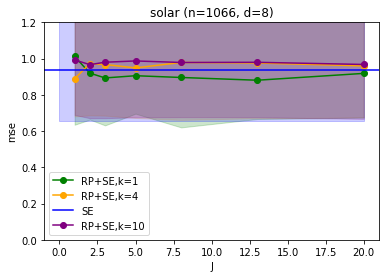

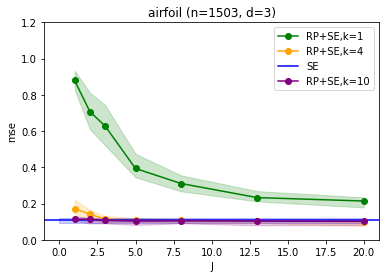

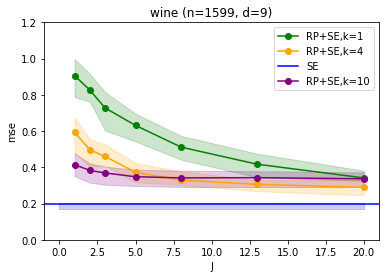

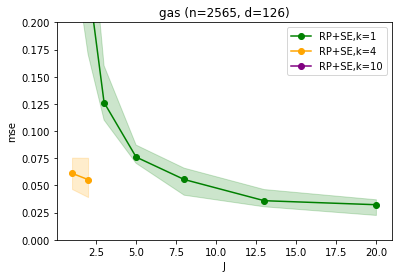

In [53]:
maxlim_list = {
    'gas': (0, 0.2)
}
for dataset in df[df['RP'] == True]['dataset'].unique():
    plt.figure()
    make_plot(1, dataset, show_range=True,  ds=df, plot_bl=False, robust=True, metric='mse')
    make_plot(4, dataset, show_range=True,  ds=df, plot_bl=False, color='orange', robust=True, metric='mse')
    if dataset == 'gas':
        make_plot(10, dataset, show_range=True,  ds=df, plot_bl=False, color='purple', robust=True, metric='mse')
    else:
        make_plot(10, dataset, show_range=True,  ds=df, plot_bl=True, color='purple', robust=True, metric='mse')   
    
    if dataset in maxlim_list.keys():
        plt.ylim(maxlim_list[dataset])
    else:
        plt.ylim(0,1.2)
    plt.legend()

# Comparison with projection kernel with learned weights

In [27]:
df_lw = pd.read_csv("./learning_weights_results.csv")
df_se = pd.read_csv('./full-run-ADAM-smoothed-lowish-cg-tol-noise-prior.csv')
df_rp = pd.read_csv('./full-correct-proj-scale-full-run-ADAM-smoothed-lowish-cg-tol-noise-prior.csv')

In [28]:
df_se_rp = pd.concat([df_rp, df_se[df_se['RP'] == False]])
df_se_rp['learn_weights'] = False
df_lw['J'] = 20
df = pd.concat([df_lw, df_se_rp])

/Users/idelbridge/miniconda3/envs/GPyTorchEnv/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  after removing the cwd from sys.path.


In [8]:
import rp_experiments

In [31]:
dsets = rp_experiments.get_small_datasets() + rp_experiments.get_medium_datasets()[:4]

In [36]:
df['group'] = None
df.loc[df['RP']==False, 'group'] = 'SE'
df.loc[(df['RP']==True) & (df['learn_weights'] == False) & (df['k']==1) & (df['J'] == 20), 'group'] = 'RP,k=1,J=20'
df.loc[(df['RP']==True) & (df['learn_weights'] == False) & (df['k']==4) & (df['J'] == 20), 'group'] = 'RP,k=4,J=20'
df.loc[(df['learn_weights'] == True) & (df['k']==1) & (df['J'] == 20), 'group'] = 'LW,k=1,J=20'

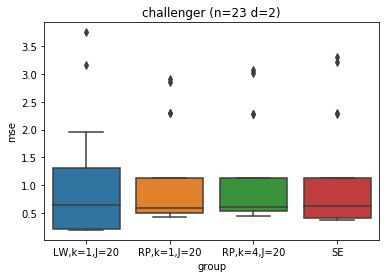

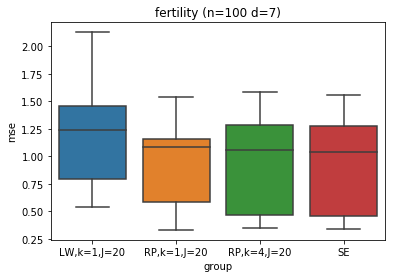

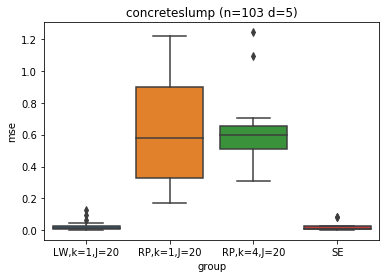

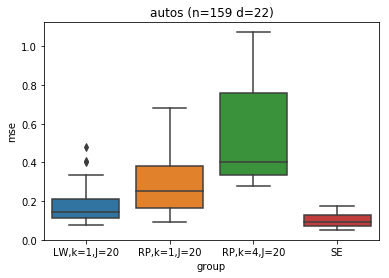

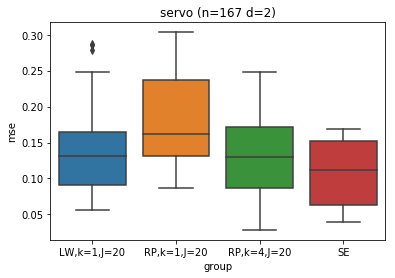

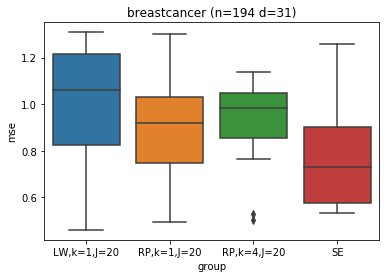

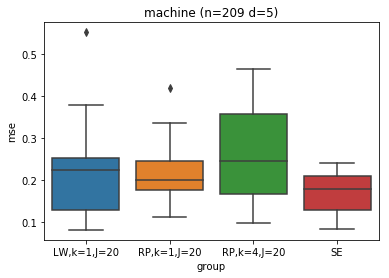

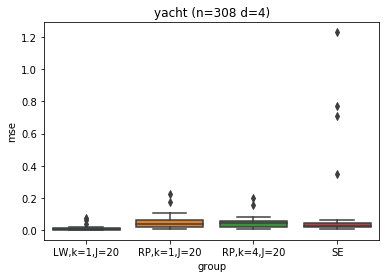

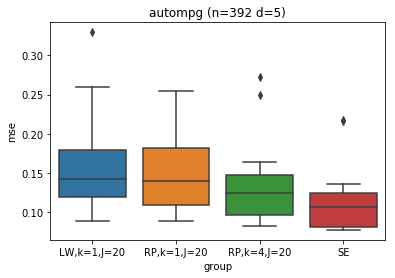

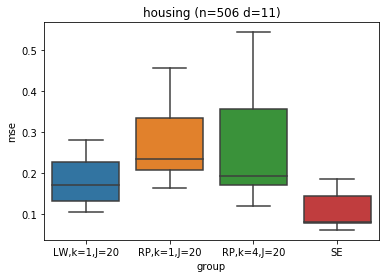

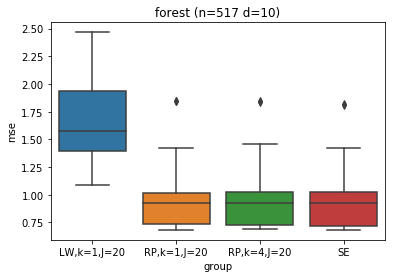

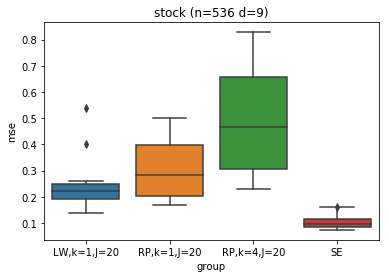

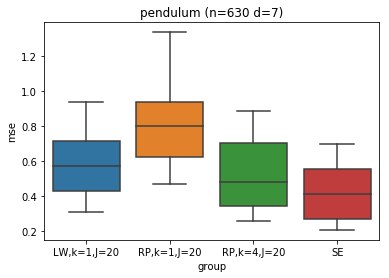

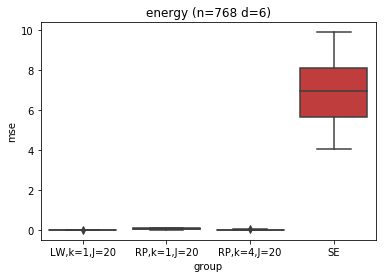

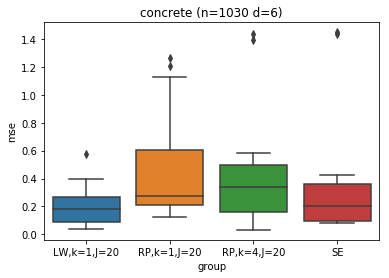

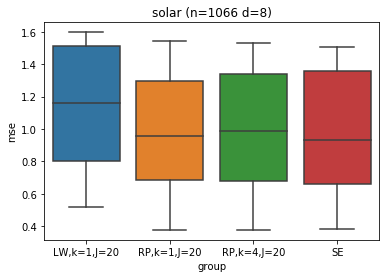

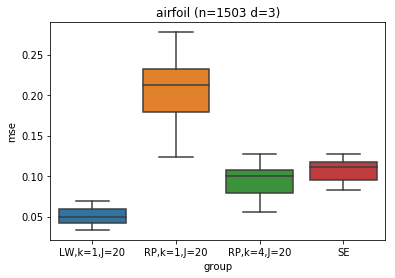

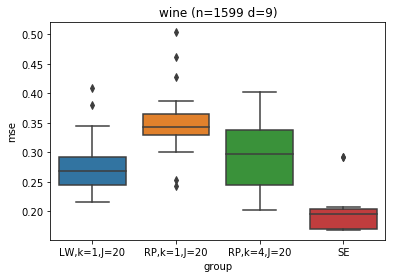

In [37]:
for dset in dsets:
    plt.figure()
    subset = df[df['dataset'] == dset]
    n = subset['n'].iloc[0]
    d = subset['d'].iloc[0]
    sns.boxplot(x='group', y='mse', data=subset)
    plt.title('{} (n={} d={})'.format(dset, n, d))

# Comparison of Scalable Methods
 * This is preliminary since there seems to be something taking a long time at test time for SKI.

In [38]:
df_sc = pd.read_csv('./scalable_methods_results.csv')

In [40]:
df_sc['group'] = None
df_sc.loc[df_sc['RP'] == False, 'group'] = 'SE+SVI'
df_sc.loc[(df_sc['RP'] == True) & (df_sc['scalable_method'] == 'ski'), 'group'] = 'RP+ski'
df_sc.loc[(df_sc['RP'] == True) & (df_sc['scalable_method'] == 'SVI'), 'group'] = 'RP+SVI'

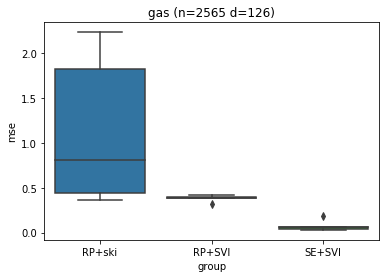

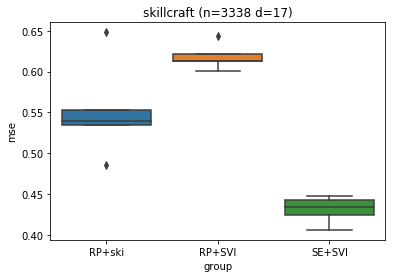

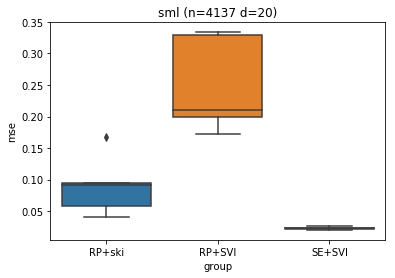

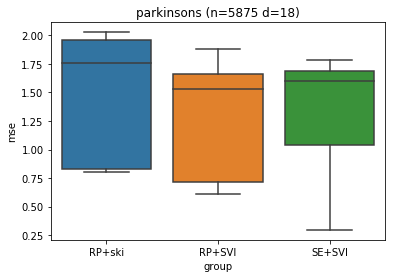

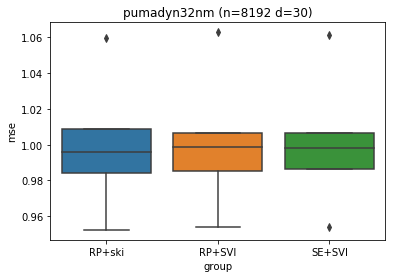

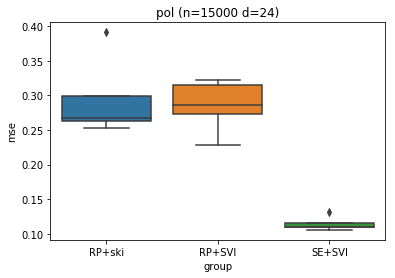

In [43]:
df_by_n = df_sc.groupby('dataset')['n'].first().sort_values()
for dset, n in df_by_n.iteritems():
    plt.figure()
    subset = df_sc[df_sc['dataset'] == dset]
    n = subset['n'].iloc[0]
    d = subset['d'].iloc[0]
    sns.boxplot(x='group', y='mse', data=subset)
    plt.title('{} (n={} d={})'.format(dset, n, d))

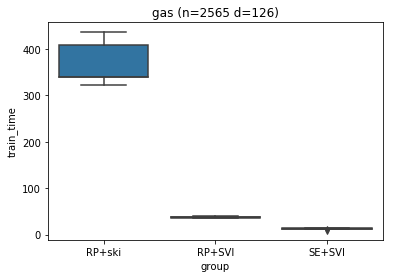

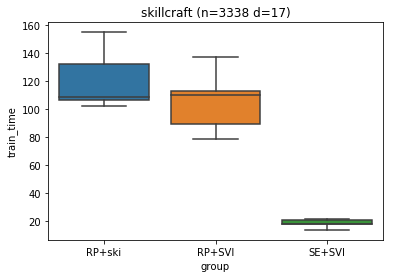

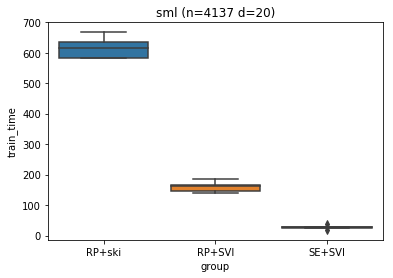

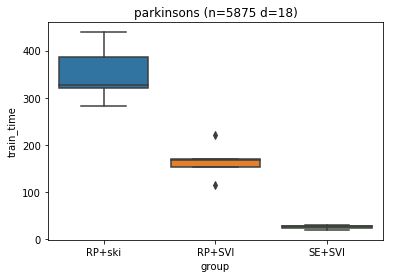

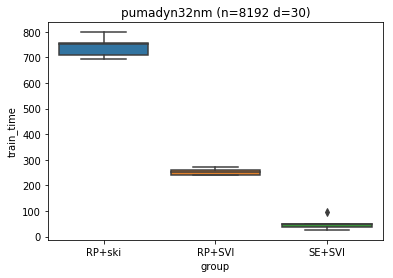

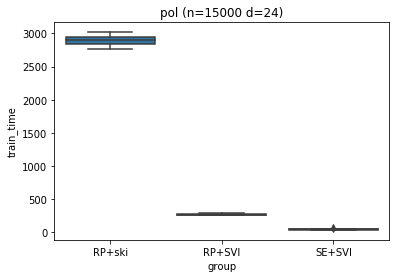

In [45]:
df_by_n = df_sc.groupby('dataset')['n'].first().sort_values()
for dset, n in df_by_n.iteritems():
    plt.figure()
    subset = df_sc[df_sc['dataset'] == dset]
    n = subset['n'].iloc[0]
    d = subset['d'].iloc[0]
    sns.boxplot(x='group', y='train_time', data=subset)
    plt.title('{} (n={} d={})'.format(dset, n, d))